In [5]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d


In [6]:
from scipy.interpolate import interp1d as interp1d

In [ ]:
### For individual flies ###
# Moco_highpass: 
# Fictrac: Bin 360 into 4 bins: binocular bin, no-see bin, left, and right bins
# Brain volume: bin brain volumes into the 4 different fictrac bins
# DF/F = [current F - aveF(no-see bin)]/aveF(no-see bin)


In [13]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_287/func_0/'

In [8]:
os.listdir('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_287/warp')

['func-to-anat.nii',
 'anat-to-meanbrain.nii',
 'anat-to-meanbrain_invtransforms_2umiso',
 'func-to-anat_invtransforms_2umiso',
 'func-to-anat_fwdtransforms_2umiso',
 'anat-to-meanbrain_fwdtransforms_2umiso']

In [14]:
save_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_287/func_0/'

In [9]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')
### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
### Unifrom the units and Make then intigers ###
stimulus_start_times = (stimulus_start_times*100).astype('int') #index needs to be an integers


####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'heading': short = 'h'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
    #fictrac[short] = np.roll(fictrac[short],400) # <------- misalignment is corrected !!!!!!
fictrac_timestamps = np.arange(0,expt_len,resolution)

fictrac['h'] = np.rad2deg(fictrac['h'])

def extract_traces(fictrac, stim_times, pre_window, post_window, behavior='Z'):
    traces = []
    for i in range(len(stim_times)):
        trace = fictrac[behavior][stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace

loading photodiode data... done


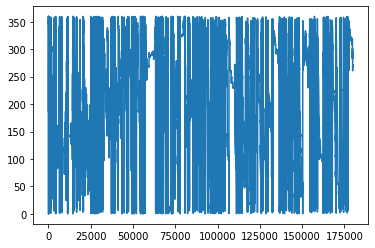

In [10]:
heading = fictrac['h']
### move negative values to be just under 360, and move nums above 360 to be just above 0
heading = heading%360
plt.plot(heading)

In [11]:
### Downsample the 100Hz fictrac data to 3384 neual data frame ###
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))
### 1. find the timestamps for neural data ###
timestamps.shape
fictrac_timestamps = np.arange(0,1800000,10)

Trying to load timestamp data from hdf5 file.
Success.


In [15]:
def interpolate_to_neural(slice_num, timestamps):
    x = timestamps[:, slice_num]
    f = interp1d(fictrac_timestamps, heading, fill_value="extrapolate") 
    ynew = f(x)
    return ynew

In [16]:
neural_file = os.path.join(func_path, 'functional_channel_2_moco_highpass.h5') #
with h5py.File(neural_file, 'r') as h:
    print(h['data'].shape)
    neural = h['data'][:]

(256, 128, 49, 3384)


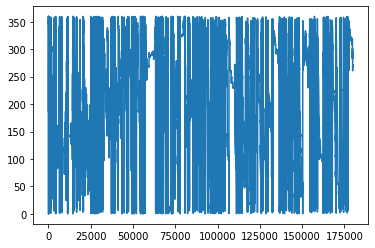

In [17]:
plt.plot(heading)

In [37]:
a = neural[:,:,20,indicies]
a.shape
# b = np.mean(a,axis=2)
# b.shape
# c = b[:,:,np.newaxis]
# c.shape

(256, 128, 1, 705)

In [28]:
d = neural[:,:,20,:]
d.shape

(256, 128, 3384)

In [30]:
e = (d-c)/c
e.shape

(256, 128, 3384)

In [34]:
f = interpolate_to_neural(20, timestamps)
indicies = np.where(np.logical_and(f>135, f<225))
np.shape(indicies)

(1, 705)

In [18]:
df_f_slice = []
for z in range(49):
    new_heading = interpolate_to_neural(z, timestamps)
    indicies = np.where(np.logical_and(new_heading>135, new_heading<225))
    temp = neural[:,:,z,indicies] ### (256,128,n) where n is # background points
    background = np.mean(temp,axis=2) ### now it is (256,128)
    
    ### neural[:,:,z,:] is (256,128,3384)
    ### (256,128)
    df_f = (neural[:,:,z,:] - background[:,:,np.newaxis]) / background[:,:,np.newaxis]
    df_f_slice.append(df_f)
df_f = np.asarray(df_f_slice) ### (256,128,49,3384)


ValueError: operands could not be broadcast together with shapes (256,128,3384) (256,128,1,695) 

In [38]:
df_f_slice = []
for z in range(49):
    new_heading = interpolate_to_neural(z, timestamps)
    indicies = np.where(np.logical_and(new_heading > 135, new_heading < 225))
    temp = neural[:,:,z,indicies]  # (256, 128,1, n) where n is # background points
    temp = np.squeeze(temp, axis=2) # Remove the singleton dimension, resulting in (256, 128, n)
    background = np.mean(temp, axis=2)  # now it is (256, 128)
    background = background[:,:,np.newaxis]  # add an extra dimension (256, 128, 1)
    
    df_f = (neural[:,:,z,:] - background) / background
    df_f_slice.append(df_f)

df_f = np.asarray(df_f_slice)  # (49, 256, 128, 3384)

In [39]:
df_f.shape

(49, 256, 128, 3384)

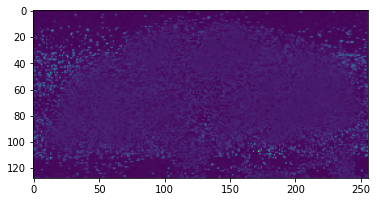

In [50]:
plt.imshow(df_f[25,:,:,1000].T)

(0.0, 100.0)

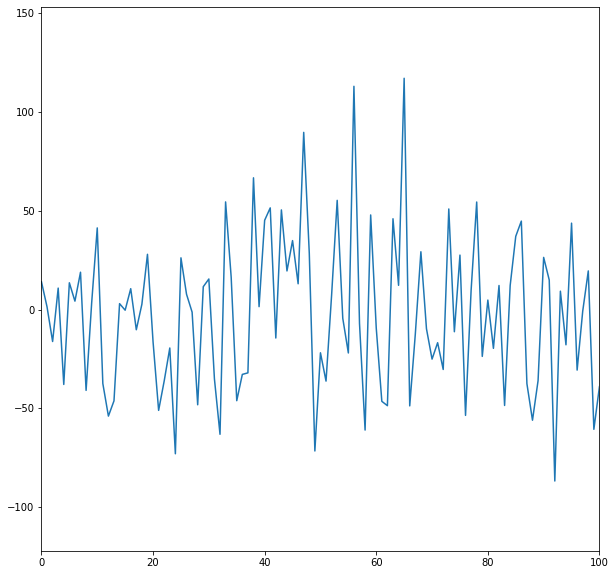

In [55]:
plt.figure(figsize=(10,10))
plt.plot(df_f[25,100,60,:]*100)
plt.xlim(0,100)

In [56]:
### save data ###
save_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_287/func_0/'
filename = 'functional_channel_2_moco_highpass_dff.npy'

# Ensure the directory path ends with a '/'
if not save_directory.endswith('/'):
    save_directory += '/'

# Construct the full file path
filepath = save_directory + filename

# Create the directory if it does not exist
os.makedirs(os.path.dirname(filepath), exist_ok=True)

# Save the array
np.save(filepath, df_f)
print(f"Array saved successfully to {filepath}")

Array saved successfully to /oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_287/func_0/functional_channel_2_moco_highpass_dff.npy


In [57]:
### transfer .npy to .h5 ####
# Load your data from a .npy file
data = np.load('functional_channel_2_moco_highpass_dff.npy')

# Ensure the directory path ends with a '/'
if not save_directory.endswith('/'):
    save_directory += '/'
# Specify the filename
filename = 'functional_channel_2_moco_highpass_dff.h5'

# Save the data to a .h5 file in the specified directory
with h5py.File(save_directory + filename, 'w') as hf:
    hf.create_dataset('functional_channel_2_moco_highpass_dff', data=data)

print(f"Data saved to {save_directory + filename}")

FileNotFoundError: [Errno 2] No such file or directory: 'functional_channel_2_moco_highpass_dff.npy'

In [ ]:
#### Show the data ####

plt.imshow ()

In [9]:
### Bin bar positions ###

In [3]:
### Bin bar positions ###
bins = np.arange(-180,181,45)
#indicies = np.digitize(heading_interpolated,bins)
# this will return something like [0,2,3,2,2,1,3,1,3,2,2,1,2,3,2,2,2]
#

In [4]:
bins

array([-180, -135,  -90,  -45,    0,   45,   90,  135,  180])

In [12]:
all_slices = []
for z in range(49):
    print(z)
    slice_neural = neural[:,:,z,:]
    
    heading_interpolated = interpolate_to_neural(z,timestamps)
    ### redefine 0
    heading_interpolated -= 180
    
    avg_neural_barposition = []
    bin_middle = []
    for i in range(len(bins)-1):
        start = bins[i]
        stop = bins[i+1]
        bin_middle.append((start+stop)/2)
        ids = np.where(np.logical_and(heading_interpolated>start, heading_interpolated<=stop))[0]
        avg_neural_barposition.append(np.mean(slice_neural[:,:,ids],axis=2))
    all_slices.append(np.asarray(avg_neural_barposition))
all_slices = np.asarray(all_slices)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [13]:
avg_neural_barposition = []
bin_middle = []
for i in range(len(bins)-1):
    start = bins[i]
    stop = bins[i+1]
    bin_middle.append((start+stop)/2)
    ids = np.where(np.logical_and(heading_interpolated>start, heading_interpolated<=stop))[0]
    avg_neural_barposition.append(np.mean(slice_neural[:,:,ids],axis=2))

In [14]:
np.arange(-180,180,45)

array([-180, -135,  -90,  -45,    0,   45,   90,  135])

In [15]:
bin_middle

[-157.5, -112.5, -67.5, -22.5, 22.5, 67.5, 112.5, 157.5]

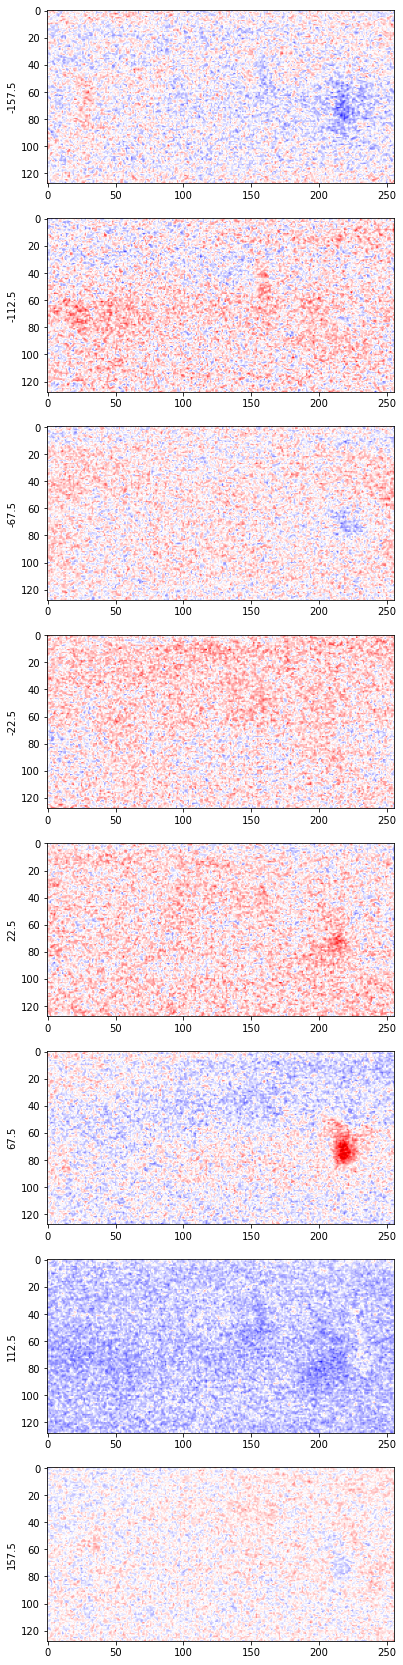

In [16]:
plt.figure(figsize=(10,30))
for i in range(len(avg_neural_barposition)):
    plt.subplot(8,1,i+1)
    plt.imshow(avg_neural_barposition[i].T,vmin=-0.5,vmax=0.5,cmap='seismic')
    plt.ylabel(bin_middle[i])